## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Markov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probability that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 

In [1]:

from numba import njit
import numpy as np
import itertools
import random
import time

#First I create the graph

vertices = ["Growing (Bull)", "Decline (Bear)", "Stagnant (Recession)"]
combinations = list(itertools.product(vertices, repeat=2))

for comb in combinations:
    print(comb) #Useful to copy paste

edges = {
    ('Growing (Bull)', 'Growing (Bull)')            : 0.9,
    ('Growing (Bull)', 'Decline (Bear)')            : 0.075,
    ('Growing (Bull)', 'Stagnant (Recession)')      : 0.025,
    ('Decline (Bear)', 'Growing (Bull)')            : 0.15,
    ('Decline (Bear)', 'Decline (Bear)')            : 0.8,
    ('Decline (Bear)', 'Stagnant (Recession)')      : 0.05,
    ('Stagnant (Recession)', 'Growing (Bull)')      : 0.25,
    ('Stagnant (Recession)', 'Decline (Bear)')      : 0.25,
    ('Stagnant (Recession)', 'Stagnant (Recession)'): 0.5        
}

print(edges)

graph = (vertices, edges)

('Growing (Bull)', 'Growing (Bull)')
('Growing (Bull)', 'Decline (Bear)')
('Growing (Bull)', 'Stagnant (Recession)')
('Decline (Bear)', 'Growing (Bull)')
('Decline (Bear)', 'Decline (Bear)')
('Decline (Bear)', 'Stagnant (Recession)')
('Stagnant (Recession)', 'Growing (Bull)')
('Stagnant (Recession)', 'Decline (Bear)')
('Stagnant (Recession)', 'Stagnant (Recession)')
{('Growing (Bull)', 'Growing (Bull)'): 0.9, ('Growing (Bull)', 'Decline (Bear)'): 0.075, ('Growing (Bull)', 'Stagnant (Recession)'): 0.025, ('Decline (Bear)', 'Growing (Bull)'): 0.15, ('Decline (Bear)', 'Decline (Bear)'): 0.8, ('Decline (Bear)', 'Stagnant (Recession)'): 0.05, ('Stagnant (Recession)', 'Growing (Bull)'): 0.25, ('Stagnant (Recession)', 'Decline (Bear)'): 0.25, ('Stagnant (Recession)', 'Stagnant (Recession)'): 0.5}


Growing (Bull)
Python time:  1.3175311088562012


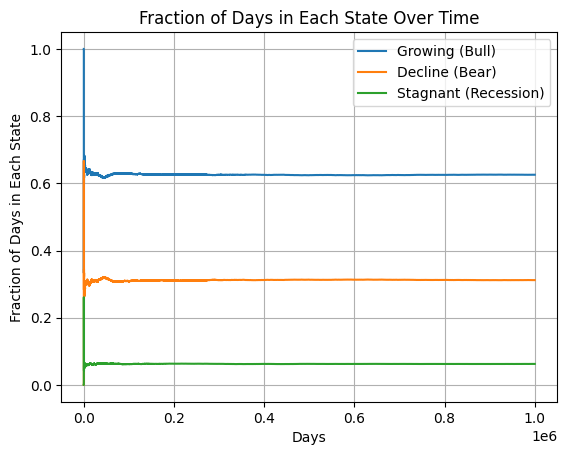

In [2]:
#Simple intuitive and very readable implementation based on dictionaries 
def evolve_the_economy(initial_state, graph, number_of_days):
    vertices, edges = graph
    count = {vertex: 0 for vertex in vertices}
    economy_history = {vertex: [] for vertex in vertices} #Keep track of the number of days in each state
    state = initial_state
    for day in range(number_of_days):
        transition_pronabilities = [ (edge[1], prob) for edge, prob in edges.items() if edge[0] == state ]
        elements, weights = zip(*transition_pronabilities)
        next_state = random.choices(elements, weights=weights, k=1)
        state = next_state[0]
        count[state] += 1
        for vertex in vertices:
            economy_history[vertex].append(count[vertex]/(day+1))  
    return economy_history



number_of_days = 1000000
def create_random_state():
    return np.random.choice(vertices)
initial_state = create_random_state()
print(initial_state)

start_python = time.time()
economy_history = evolve_the_economy(initial_state, graph, number_of_days)
end_python = time.time()
print("Python time: ", end_python - start_python)


import matplotlib.pyplot as plt
# Plot the fraction of days in each state over time
for vertex in vertices:
    plt.plot(range(number_of_days), economy_history[vertex], label=vertex)

plt.title('Fraction of Days in Each State Over Time')
plt.xlabel('Days')
plt.ylabel('Fraction of Days in Each State')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from numba import njit, jit


#Now I want to make this function numba compatible njit

#First of all I decide to rely entirely on numpy and not dicts withc do not seem to be compatible
edges_dict = edges

#I want to convert everything into numpy format, less intuitive but worth it
edges_list = []
for (from_vertex, to_vertex), prob in edges_dict.items():
    from_idx = vertices.index(from_vertex) #in this way everything relies on the position of the element in the original list. this is solid if someone swithces convention
    to_idx = vertices.index(to_vertex)
    #print(type(from_idx))
    edges_list.append([from_idx, to_idx, prob]) #list using 2D array but will convert everty type to float
edges_np = np.array(edges_list)

print(edges_np) #check that it makes sense

print("Vertices:", vertices) 
print("Edges array:\n", edges_np) #check that it is ok


def evolve_the_economy(initial_state, vertices, edges, number_of_days):
    count = np.zeros(len(vertices)) #one positon for each vertex
    economy_history = np.zeros((len(vertices), number_of_days))  #one position for each day to be filled later
    #print(economy_history.shape) #check
    state_idx = vertices.index(initial_state)  #In this way the correct order is delegated to the list indices so that it will be always consistent even if one swithces
    count[state_idx] += 1
    
    for day in range(number_of_days): #loop over the number of days that the simulation is running
       
        transition_probabilities = []
        next_states = []
        for i in range(len(edges)): #loop over the edges
            if edges[i, 0] == state_idx: #the first time this will be the initial state, later it will be the current state
                next_states.append(edges[i, 1])
                transition_probabilities.append(edges[i, 2])
        #print(len(next_states)) #should always be 3 unless not well defined graph
        #print(type(next_states[0]))
        
        if len(next_states) != 3:
            raise ValueError(f"No valid transitions from state {state_idx} on day {day}")

        #check that the graph is well defined
        transition_probabilities = np.array(transition_probabilities)
        if np.sum(transition_probabilities) != 1.0: #has to be well defined graph
            raise ValueError(f"transition probabilities do not sum to 1 on day {day}")

        #option of the np.random.choice for weighted prob does not work so I found workaround
        random_value = np.random.rand()  #random number in [0,1]
        cumulative_probabilities = np.cumsum(transition_probabilities)
        
        #geometrically this represent the weighted probability as a segment on the real number lines of lenght proportional to the probability
        for i in (0,1,2):
            if random_value < cumulative_probabilities[i]: #this will guarantee that the portion of the segment before the next value is cut away
                next_state_idx = next_states[i]
                break #stop when condition is met

        #has to be int
        #print(next_state_idx)
        #print(type(next_state_idx))
        next_state_idx = int(next_state_idx)

        #This should always be the case if the graph is well defined
        if next_state_idx < 0 or next_state_idx >= len(vertices):
            raise ValueError(f"invalid index on day {day}")

        state_idx = next_state_idx #the current state becomes the next one
        count[state_idx] += 1
        
        #Save the results of this day
        for i in range(len(vertices)):
            economy_history[i, day] = count[i] / (day + 1)
    
    return economy_history
c_evolve_the_economy = njit(evolve_the_economy)

[[0.    0.    0.9  ]
 [0.    1.    0.075]
 [0.    2.    0.025]
 [1.    0.    0.15 ]
 [1.    1.    0.8  ]
 [1.    2.    0.05 ]
 [2.    0.    0.25 ]
 [2.    1.    0.25 ]
 [2.    2.    0.5  ]]
Vertices: ['Growing (Bull)', 'Decline (Bear)', 'Stagnant (Recession)']
Edges array:
 [[0.    0.    0.9  ]
 [0.    1.    0.075]
 [0.    2.    0.025]
 [1.    0.    0.15 ]
 [1.    1.    0.8  ]
 [1.    2.    0.05 ]
 [2.    0.    0.25 ]
 [2.    1.    0.25 ]
 [2.    2.    0.5  ]]


In [4]:
import time
number_of_days = 1000
def create_random_state():
    return np.random.choice(vertices)
initial_state = create_random_state()
print(initial_state)

start_python = time.time()
economy_history = evolve_the_economy(initial_state, vertices, edges_np, number_of_days)
end_python = time.time()
duration = end_python - start_python
print("Python time: ", duration)

start_numba = time.time()
c_economy_history = c_evolve_the_economy(initial_state, vertices, edges_np, number_of_days)
end_numba = time.time()
c_duration = end_numba - start_numba
print("Numba time: ", c_duration)

#check that the proportions are converged to the same values after many iterations:
print(economy_history[:,-1])
print(c_economy_history[:,-1])
for i in range(len(economy_history[:,1])):
    print(c_economy_history[i,-1]/economy_history[i,-1])


Decline (Bear)
Python time:  0.02575516700744629
Numba time:  1.8250207901000977
[0.654 0.282 0.065]
[0.579 0.372 0.05 ]
0.8853211009174311
1.319148936170213
0.7692307692307693


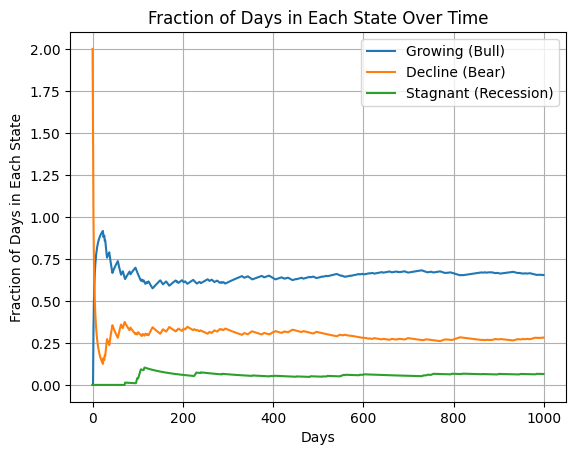

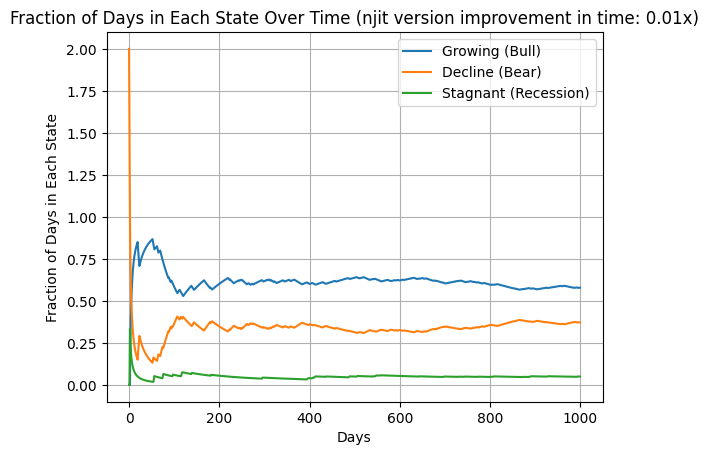

In [5]:
import matplotlib.pyplot as plt

def create_economy_plot():
    for i, vertex in enumerate(vertices):
        plt.plot(range(number_of_days), economy_history[i, :], label=vertex)

    plt.title('Fraction of Days in Each State Over Time')
    plt.xlabel('Days')
    plt.ylabel('Fraction of Days in Each State')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()


def create_c_economy_plot():
    for i, vertex in enumerate(vertices):
        plt.plot(range(number_of_days), c_economy_history[i, :], label=vertex)

    plt.title(f'Fraction of Days in Each State Over Time (njit version improvement in time: {duration / c_duration:.2f}x)')
    plt.xlabel('Days')
    plt.ylabel('Fraction of Days in Each State')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

create_economy_plot()
create_c_economy_plot()


## Q2: Consistent plotting

(This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should initialize a matplotlib figure with the options that you like the most (fontsize, ticks, etc etc)
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifull, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my python module [skywalker](https://github.com/dgerosa/skywalker).  

### I will implement the suggestions for Diversity and Inclusion provided by Neutrino2024 conference:

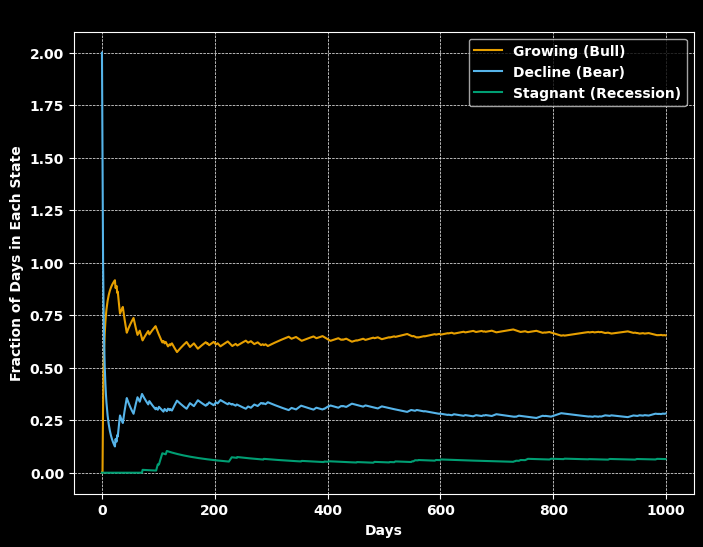

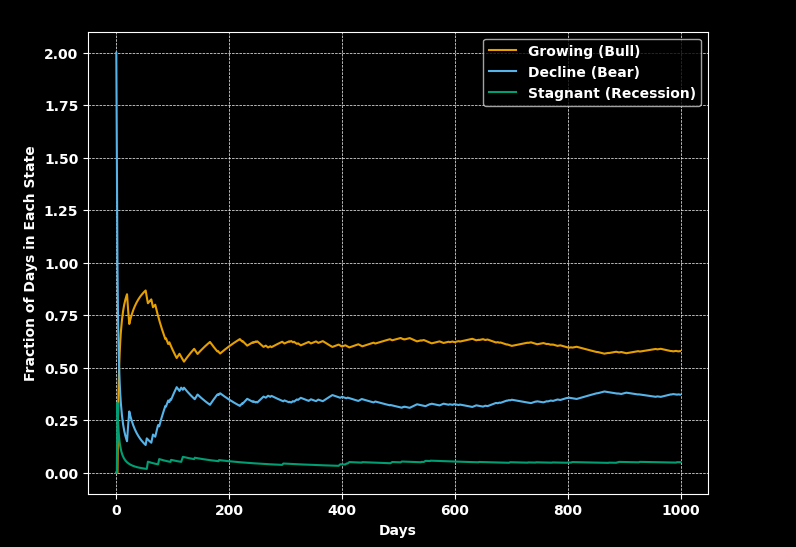

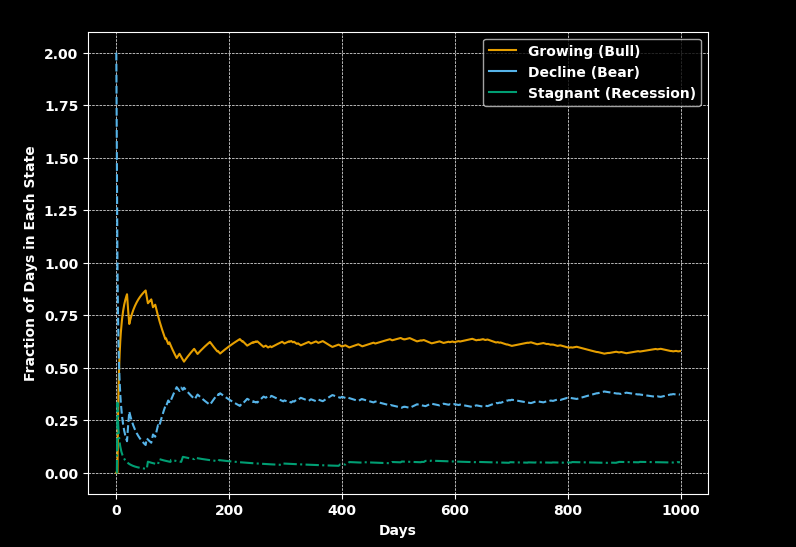

In [7]:
import matplotlib.pyplot as plt
from functools import wraps

def myplot(num_colors=4, save_path='plot.pdf'):
    #color blind friendly palette provided by Neutrino2024 organizers
    color_blind_palette = [
        '#E69F00',  # orange
        '#56B4E9',  # sky lbue
        '#009E73',  # bluish green
        '#F0E442',  # yellow
        '#0072B2',  # blue
        '#D55E00',  # vermilion
        '#CC79A7',  # reddish purple
        '#ffffff'   # white (for contrast on black background)
    ]

    #redundant coding makes it even more color-blind friendly
    line_styles = ['-', '--', '-.', ':'] 
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
            plt.rcParams['font.family'] = 'Sans Serif' #this is just because I like it not because it is more readable

            #set everything bold and big
            plt.rcParams['font.weight'] = 'bold' 
            plt.rcParams['axes.labelweight'] = 'bold' 
            plt.rcParams['axes.titleweight'] = 'bold' 
            plt.rcParams['legend.fontsize'] = 10
            plt.rcParams['xtick.labelsize'] = 10
            plt.rcParams['ytick.labelsize'] = 10


            plt.grid(True, which='both', axis='both', color='white', linestyle='--', linewidth=0.5)
            plt.rcParams['axes.facecolor'] = 'black'
            plt.rcParams['figure.facecolor'] = 'black'
            plt.rcParams['legend.facecolor'] = 'black'
            
            #set everything to white for contrast
            plt.rcParams['axes.labelcolor'] = 'white'
            plt.rcParams['xtick.color'] = 'white'
            plt.rcParams['ytick.color'] = 'white'
            plt.rcParams['legend.labelcolor'] = 'white'
            plt.rcParams['axes.edgecolor'] = 'white'
            
            #the color palette is based on the number of colors
            color_selection_table = {
                2: [color_blind_palette[1], color_blind_palette[5]],  # Orange, Blue
                4: [color_blind_palette[0], color_blind_palette[4], color_blind_palette[5], color_blind_palette[6]],  # Black, Yellow, Blue, Vermilion
                6: [color_blind_palette[0], color_blind_palette[1], color_blind_palette[2], color_blind_palette[4], color_blind_palette[5], color_blind_palette[6]],  # Black, Orange, Sky Blue, Yellow, Blue, Vermilion
                8: color_blind_palette  # All colors
            }
            selected_palette = color_selection_table.get(num_colors, color_blind_palette)

            
            selected_palette = color_selection_table.get(num_colors, color_blind_palette)
            plt.rcParams['axes.prop_cycle'] = plt.cycler(color=selected_palette)

           
            # Generate marker and line styles based on the redundant coding
            num_lines = len(selected_palette)  # Assuming each color gets a line
            combined_styles = [line_styles[i % len(line_styles)] for i in range(num_lines)]

            # Apply the redundant styles to the plots inside the function
            # Use the existing ax and plot, handling everything internally
            original_func_result = func(*args, **kwargs)

            # We assume that the user is plotting multiple lines. We need to go over each line
            lines = ax.get_lines()  # Retrieve lines plotted on the axis
            
            # Apply the redundant styles to each line
            for i, line in enumerate(lines):
                line.set_linestyle(combined_styles[i % len(combined_styles)])

            # Save the figure to PDF
            fig.savefig(save_path, format='pdf', bbox_inches='tight')

            plt.show(fig)
            

            return fig
            
            
        return wrapper
    return decorator

#as an example I use the previous plots
my_economy_plot = myplot(num_colors=3, save_path="economy_plot.pdf")(create_economy_plot) #3 colors for 3 states
my_c_economy_plot = myplot(num_colors=3,save_path="c_economy_plot.pdf")(create_c_economy_plot) #3 colors for 3 states

my_economy_plot()
my_c_economy_plot()
